In [1]:
 !pip install pandas numpy matplotlib seaborn tensorflow nltk scikit-learn

In [3]:
!python -m nltk.downloader punkt stopwords wordnet

<frozen runpy>:128: RuntimeWarning: 'nltk.downloader' found in sys.modules after import of package 'nltk', but prior to execution of 'nltk.downloader'; this may result in unpredictable behaviour
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\rcoem\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\rcoem\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\rcoem\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
import pickle
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.regularizers import l2
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import nltk
from sklearn.metrics.pairwise import cosine_similarity
from tensorflow.keras.optimizers import Adam

In [7]:
# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

In [9]:
# Load and preprocess the data
def load_data(file_path='new_dataset.csv'):
    """
    Load data from CSV file
    """
    print(f"Loading data from {file_path}...")
    df = pd.read_csv(file_path)
    print(f"Loaded dataset with {df.shape[0]} rows and {df.shape[1]} columns")
    
    # Display dataset info
    print("\nDataset Info:")
    print(df.info())
    
    # Check for missing values
    missing_values = df.isnull().sum()
    if missing_values.sum() > 0:
        print("\nMissing values in the dataset:")
        print(missing_values[missing_values > 0])
        
        # Handle missing values
        print("Handling missing values...")
        df = df.dropna(subset=['Question', 'Desired_answer', 'Student_answer', 'score_avg'])
        print(f"Dataset after handling missing values: {df.shape[0]} rows")
    
    return df


In [11]:
# Text preprocessing functions
def preprocess_text(text):
    """Preprocess text by lowercasing, removing punctuation, stopwords, and lemmatizing"""
    if not isinstance(text, str):
        return ""
        
    # Convert to lowercase
    text = text.lower()
    
    # Remove punctuation
    text = re.sub(r'[^\w\s]', '', text)
    
    # Tokenize
    tokens = word_tokenize(text)
    
    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words]
    
    # Lemmatize
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
    
    return ' '.join(tokens)


In [13]:
# Feature engineering
def extract_features(df):
    """Extract features for model training"""
    
    print("Extracting features...")
    
    # Preprocess text columns
    print("Preprocessing text columns...")
    df['processed_question'] = df['Question'].apply(preprocess_text)
    df['processed_desired_answer'] = df['Desired_answer'].apply(preprocess_text)
    df['processed_student_answer'] = df['Student_answer'].apply(preprocess_text)
    
    # Calculate text length features
    print("Calculating text length features...")
    df['student_answer_length'] = df['Student_answer'].apply(lambda x: len(x.split()) if isinstance(x, str) else 0)
    df['desired_answer_length'] = df['Desired_answer'].apply(lambda x: len(x.split()) if isinstance(x, str) else 0)
    df['length_difference'] = abs(df['student_answer_length'] - df['desired_answer_length'])
    
    # Calculate word overlap
    def word_overlap_ratio(text1, text2):
        if not isinstance(text1, str) or not isinstance(text2, str):
            return 0
        
        words1 = set(text1.split())
        words2 = set(text2.split())
        
        if len(words1) == 0 or len(words2) == 0:
            return 0
            
        overlap = len(words1.intersection(words2))
        return overlap / max(len(words1), len(words2))
    
    print("Calculating word overlap ratio...")
    df['word_overlap_ratio'] = df.apply(
        lambda row: word_overlap_ratio(row['processed_student_answer'], row['processed_desired_answer']), 
        axis=1
    )
    
    # Calculate cosine similarity between student answer and desired answer
    def get_cosine_sim(text1, text2):
        if not isinstance(text1, str) or not isinstance(text2, str):
            return 0
        
        # Tokenize and create term frequency vectors
        all_words = set(text1.split() + text2.split())
        
        if not all_words:
            return 0
            
        vec1 = [text1.split().count(word) for word in all_words]
        vec2 = [text2.split().count(word) for word in all_words]
        
        # Calculate cosine similarity
        vec1 = np.array(vec1).reshape(1, -1)
        vec2 = np.array(vec2).reshape(1, -1)
        
        if np.sum(vec1) == 0 or np.sum(vec2) == 0:
            return 0
            
        return cosine_similarity(vec1, vec2)[0][0]
    
    print("Calculating cosine similarity...")
    df['cosine_similarity'] = df.apply(
        lambda row: get_cosine_sim(row['processed_student_answer'], row['processed_desired_answer']), 
        axis=1
    )
    
    # Use 'score_avg' as the target variable
    df['target_score'] = df['score_avg']
    
    # Print feature statistics
    print("\nFeature Statistics:")
    print(df[['student_answer_length', 'desired_answer_length', 'length_difference', 
              'word_overlap_ratio', 'cosine_similarity', 'target_score']].describe())
    
    # Create a correlation heatmap
    corr = df[['student_answer_length', 'desired_answer_length', 'length_difference', 
              'word_overlap_ratio', 'cosine_similarity', 'target_score']].corr()
    plt.figure(figsize=(10, 8))
    sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
    plt.title('Feature Correlation Heatmap')
    plt.tight_layout()
    plt.savefig('feature_correlation.png')
    
    return df



In [15]:
# Tokenize and prepare sequences
def prepare_sequences(df, max_words=10000, max_seq_length=150):
    """Tokenize and prepare sequences for LSTM model"""
    
    print(f"Preparing sequences with max_words={max_words}, max_seq_length={max_seq_length}...")
    
    # Tokenize the text
    tokenizer = Tokenizer(num_words=max_words, oov_token='<OOV>')
    tokenizer.fit_on_texts(df['processed_student_answer'].tolist() + df['processed_desired_answer'].tolist())
    
    print(f"Vocabulary size: {len(tokenizer.word_index) + 1}")
    
    # Convert texts to sequences
    student_sequences = tokenizer.texts_to_sequences(df['processed_student_answer'])
    desired_sequences = tokenizer.texts_to_sequences(df['processed_desired_answer'])
    
    # Pad sequences
    student_padded = pad_sequences(student_sequences, maxlen=max_seq_length, padding='post')
    desired_padded = pad_sequences(desired_sequences, maxlen=max_seq_length, padding='post')
    
    # Save tokenizer
    with open('answer_tokenizer.pickle', 'wb') as handle:
        pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
    print("Tokenizer saved as 'answer_tokenizer.pickle'")
    
    # Prepare additional features
    additional_features = df[['cosine_similarity', 'word_overlap_ratio', 'length_difference']].values
    
    return student_padded, desired_padded, additional_features, tokenizer



In [17]:
# Build enhanced LSTM model
def build_model(tokenizer, max_seq_length=150, embedding_dim=200, include_additional_features=True, num_additional_features=3):
    """Build a Bidirectional LSTM model with regularization and additional features"""
    
    vocab_size = min(len(tokenizer.word_index) + 1, 10000)  # Limit vocab size
    
    # Input for student answer
    student_input = tf.keras.Input(shape=(max_seq_length,), name='student_input')
    
    # Embedding and LSTM layers for student answer
    embedding = Embedding(vocab_size, embedding_dim, input_length=max_seq_length)(student_input)
    dropout1 = Dropout(0.3)(embedding)
    bilstm1 = Bidirectional(LSTM(128, return_sequences=True, kernel_regularizer=l2(0.001)))(dropout1)
    dropout2 = Dropout(0.3)(bilstm1)
    bilstm2 = Bidirectional(LSTM(64, kernel_regularizer=l2(0.001)))(dropout2)
    dropout3 = Dropout(0.3)(bilstm2)
    
    # Include additional handcrafted features if specified
    if include_additional_features:
        additional_input = tf.keras.Input(shape=(num_additional_features,), name='additional_features')
        
        # Concatenate LSTM output with additional features
        concatenated = tf.keras.layers.concatenate([dropout3, additional_input])
        
        # Dense layers
        dense1 = Dense(64, activation='relu', kernel_regularizer=l2(0.001))(concatenated)
        dropout4 = Dropout(0.3)(dense1)
        dense2 = Dense(32, activation='relu', kernel_regularizer=l2(0.001))(dropout4)
        dropout5 = Dropout(0.2)(dense2)
        dense3 = Dense(16, activation='relu', kernel_regularizer=l2(0.001))(dropout5)
        
        # Output layer
        output = Dense(1, activation='linear')(dense3)
        
        # Create model with both inputs
        model = tf.keras.Model(inputs=[student_input, additional_input], outputs=output)
    else:
        # Dense layers
        dense1 = Dense(64, activation='relu', kernel_regularizer=l2(0.001))(dropout3)
        dropout4 = Dropout(0.3)(dense1)
        dense2 = Dense(32, activation='relu', kernel_regularizer=l2(0.001))(dropout4)
        dropout5 = Dropout(0.2)(dense2)
        dense3 = Dense(16, activation='relu', kernel_regularizer=l2(0.001))(dropout5)
        
        # Output layer
        output = Dense(1, activation='linear')(dense3)
        
        # Create model with just student input
        model = tf.keras.Model(inputs=student_input, outputs=output)
    
    # Compile model with Adam optimizer and learning rate
    optimizer = Adam(learning_rate=0.001)
    model.compile(loss='mean_squared_error', optimizer=optimizer, metrics=['mae'])
    
    return model



In [19]:
# Train model
def train_model(model, X_train, y_train, X_valid, y_valid, epochs=50, batch_size=32):
    """Train the model with early stopping and checkpointing"""
    
    print(f"Training model with {epochs} epochs and batch size {batch_size}...")
    
    # Callbacks
    early_stopping = EarlyStopping(
        monitor='val_loss',
        patience=10,
        restore_best_weights=True
    )
    
    model_checkpoint = ModelCheckpoint(
        'best_model.keras',
        monitor='val_loss',
        save_best_only=True,
        verbose=1
    )
    
    # Reduce learning rate when plateau
    reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.2,
        patience=5,
        min_lr=0.00001,
        verbose=1
    )
    
    # Train model
    history = model.fit(
        X_train, y_train,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(X_valid, y_valid),
        callbacks=[early_stopping, model_checkpoint, reduce_lr],
        verbose=1
    )
    
    return history, model



In [21]:
# Evaluate model
def evaluate_model(model, X_test, y_test):
    """Evaluate the model and print performance metrics"""
    
    print("Evaluating model...")
    
    # Make predictions
    y_pred = model.predict(X_test)
    
    # Round predictions to nearest 0.5
    y_pred_rounded = np.round(y_pred * 2) / 2
    
    # Ensure predictions are in valid range (1-5)
    y_pred_rounded = np.clip(y_pred_rounded, 1, 5)
    
    # Calculate metrics
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    
    print(f"Mean Squared Error: {mse:.4f}")
    print(f"Mean Absolute Error: {mae:.4f}")
    print(f"R² Score: {r2:.4f}")
    
    # Calculate accuracy with different tolerances
    tolerance_05 = np.mean(abs(y_test - y_pred_rounded) <= 0.5)
    tolerance_10 = np.mean(abs(y_test - y_pred_rounded) <= 1.0)
    
    print(f"Accuracy (±0.5 points): {tolerance_05:.4f}")
    print(f"Accuracy (±1.0 points): {tolerance_10:.4f}")
    
    return mse, mae, r2, y_pred, y_pred_rounded



In [23]:

# Visualize results
def visualize_results(history, y_test, y_pred, y_pred_rounded):
    """Visualize training history and prediction results"""
    
    print("Visualizing results...")
    
    # Plot training history
    plt.figure(figsize=(12, 4))
    
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(history.history['mae'], label='Train MAE')
    plt.plot(history.history['val_mae'], label='Validation MAE')
    plt.title('Training and Validation MAE')
    plt.xlabel('Epochs')
    plt.ylabel('MAE')
    plt.legend()
    
    plt.tight_layout()
    plt.savefig('training_history.png')
    plt.show()
    
    # Plot predictions vs actual
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    plt.scatter(y_test, y_pred, alpha=0.5)
    plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'r--')
    plt.title('Actual vs Predicted Scores')
    plt.xlabel('Actual Score')
    plt.ylabel('Predicted Score')
    
    plt.subplot(1, 2, 2)
    plt.scatter(y_test, y_pred_rounded, alpha=0.5)
    plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], 'r--')
    plt.title('Actual vs Rounded Predicted Scores')
    plt.xlabel('Actual Score')
    plt.ylabel('Rounded Predicted Score')
    
    plt.tight_layout()
    plt.savefig('prediction_results.png')
    plt.show()
    
    # Plot prediction error distribution
    error = y_test - y_pred_rounded
    plt.figure(figsize=(10, 6))
    sns.histplot(error, bins=15, kde=True)
    plt.title('Prediction Error Distribution')
    plt.xlabel('Error (Actual - Predicted)')
    plt.ylabel('Frequency')
    plt.grid(True, alpha=0.3)
    plt.savefig('error_distribution.png')
    plt.show()
    
    # Plot score distribution
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    sns.histplot(y_test, bins=9, alpha=0.5, label='Actual', kde=True)
    sns.histplot(y_pred_rounded, bins=9, alpha=0.5, label='Predicted', kde=True)
    plt.title('Score Distribution')
    plt.xlabel('Score')
    plt.ylabel('Frequency')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    sns.boxplot(data=pd.DataFrame({'Actual': y_test.flatten(), 'Predicted': y_pred.flatten()}).melt())
    plt.title('Score Distributions (Box Plot)')
    
    plt.tight_layout()
    plt.savefig('score_distribution.png')
    plt.show()



In [25]:

# Save model and prediction
def save_model_and_results(model, tokenizer, df, y_pred, y_pred_rounded):
    """Save the model, tokenizer, and prediction results"""
    
    print("Saving model and results...")
    
    # Save model
    model.save('subjective_answer_evaluation.keras')
    
    # Save tokenizer
    with open('answer_tokenizer.pickle', 'wb') as handle:
        pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
    # Save predictions
    results_df = df.copy()
    results_df['predicted_score'] = y_pred
    results_df['predicted_score_rounded'] = y_pred_rounded
    results_df['error'] = abs(results_df['target_score'] - results_df['predicted_score_rounded'])
    
    results_df.to_csv('prediction_results.csv', index=False)
    
    print("Model saved as 'subjective_answer_evaluation.keras'")
    print("Tokenizer saved as 'answer_tokenizer.pickle'")
    print("Predictions saved as 'prediction_results.csv'")


In [27]:

# Function to create a prediction pipeline
def create_prediction_pipeline(saved_model_path, tokenizer_path, max_seq_length=150, include_additional_features=True):
    """Create a pipeline for making predictions on new data"""
    
    print("Creating prediction pipeline...")
    
    # Load model and tokenizer
    model = load_model(saved_model_path)
    
    with open(tokenizer_path, 'rb') as handle:
        tokenizer = pickle.load(handle)
    
    def predict_score(question, desired_answer, student_answer):
        # Preprocess texts
        processed_question = preprocess_text(question)
        processed_desired_answer = preprocess_text(desired_answer)
        processed_student_answer = preprocess_text(student_answer)
        
        # Calculate cosine similarity
        all_words = set(processed_desired_answer.split() + processed_student_answer.split())
        if all_words:
            vec1 = [processed_desired_answer.split().count(word) for word in all_words]
            vec2 = [processed_student_answer.split().count(word) for word in all_words]
            
            vec1 = np.array(vec1).reshape(1, -1)
            vec2 = np.array(vec2).reshape(1, -1)
            
            if np.sum(vec1) > 0 and np.sum(vec2) > 0:
                cosine_sim = cosine_similarity(vec1, vec2)[0][0]
            else:
                cosine_sim = 0
        else:
            cosine_sim = 0
        
        # Calculate word overlap ratio
        words1 = set(processed_desired_answer.split())
        words2 = set(processed_student_answer.split())
        
        if len(words1) > 0 and len(words2) > 0:
            overlap = len(words1.intersection(words2))
            word_overlap = overlap / max(len(words1), len(words2))
        else:
            word_overlap = 0
        
        # Calculate length difference
        len_diff = abs(len(processed_desired_answer.split()) - len(processed_student_answer.split()))
        
        # Convert to sequences and pad
        student_seq = tokenizer.texts_to_sequences([processed_student_answer])
        student_padded = pad_sequences(student_seq, maxlen=max_seq_length, padding='post')
        
        # Create additional features array
        additional_features = np.array([[cosine_sim, word_overlap, len_diff]])
        
        # Make prediction
        if include_additional_features:
            prediction = model.predict([student_padded, additional_features])[0][0]
        else:
            prediction = model.predict(student_padded)[0][0]
        
        # Round to nearest 0.5
        rounded_prediction = round(prediction * 2) / 2
        
        # Ensure prediction is in valid range (1-5)
        rounded_prediction = max(1, min(5, rounded_prediction))
        
        return {
            'original_prediction': float(prediction),
            'rounded_prediction': float(rounded_prediction),
            'cosine_similarity': float(cosine_sim),
            'word_overlap_ratio': float(word_overlap),
            'feature_importance': {
                'cosine_similarity': 'High correlation with scoring',
                'word_overlap_ratio': 'Medium correlation with scoring',
                'length_difference': 'Lower correlation with scoring'
            }
        }
    
    return predict_score



In [35]:
# Main function to execute the entire workflow
def main():
    # Load data - specify your actual dataset file here
    print("Starting subjective answer evaluation system...")
    df = load_data('new_dataset.csv')
    
    # Extract features
    df = extract_features(df)
    
    # Prepare sequences and additional features
    student_padded, desired_padded, additional_features, tokenizer = prepare_sequences(df)
    
    # Prepare inputs based on model type
    include_additional_features = True  # Set to True to use additional handcrafted features
    
    if include_additional_features:
        X = [student_padded, additional_features]
    else:
        X = student_padded
        
    y = df['target_score'].values.reshape(-1, 1)
    
    # Split data
    # For larger datasets, consider using a smaller test/validation ratio
    test_size = 0.15
    print(f"Splitting data with test_size={test_size}...")
    
    if include_additional_features:
        # Split for multi-input model
        X_student_train, X_student_temp, X_features_train, X_features_temp, y_train, y_temp = train_test_split(
            student_padded, additional_features, y, test_size=test_size*2, random_state=42
        )
        
        X_student_valid, X_student_test, X_features_valid, X_features_test, y_valid, y_test = train_test_split(
            X_student_temp, X_features_temp, y_temp, test_size=0.5, random_state=42
        )
        
        X_train = [X_student_train, X_features_train]
        X_valid = [X_student_valid, X_features_valid]
        X_test = [X_student_test, X_features_test]
    else:
        # Split for single-input model
        X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=test_size*2, random_state=42)
        X_valid, X_test, y_valid, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)
    
    print(f"Training set size: {len(y_train)}")
    print(f"Validation set size: {len(y_valid)}")
    print(f"Test set size: {len(y_test)}")
    
    # Build model
    print("Building model...")
    model = build_model(tokenizer, 
                      max_seq_length=student_padded.shape[1], 
                      include_additional_features=include_additional_features,
                      num_additional_features=additional_features.shape[1] if include_additional_features else 0)
    
    # Print model summary
    model.summary()
    
    # Train model
    history, trained_model = train_model(model, X_train, y_train, X_valid, y_valid, epochs=100, batch_size=64)
    
    # Evaluate model
    mse, mae, r2, y_pred, y_pred_rounded = evaluate_model(trained_model, X_test, y_test)
    
    # Visualize results
    visualize_results(history, y_test, y_pred, y_pred_rounded)
    
    # Save model and results
    save_model_and_results(trained_model, tokenizer, df.iloc[-len(y_pred):], y_pred, y_pred_rounded)

    # Create prediction pipeline
    predict_score = create_prediction_pipeline('subjective_answer_evaluation.keras', 
                                            'answer_tokenizer.pickle',
                                            include_additional_features=include_additional_features)
    
    # Example prediction
    example_prediction = predict_score(
        "What is the role of a prototype?",
        "To simulate the behavior of the actual system.",
        "A prototype helps in identifying potential issues in the system design."
    )
    
    print("\nExample prediction:")
    print(f"Question: What is the role of a prototype?")
    print(f"Desired answer: To simulate the behavior of the actual system.")
    print(f"Student answer: A prototype helps in identifying potential issues in the system design.")
    print(f"Predicted score: {example_prediction['rounded_prediction']}/5")
    print(f"Cosine similarity: {example_prediction['cosine_similarity']:.4f}")
    
    print("\nModel training and evaluation completed successfully.")



Starting subjective answer evaluation system...
Loading data from new_dataset.csv...
Loaded dataset with 4005 rows and 7 columns

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4005 entries, 0 to 4004
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   id              4005 non-null   object 
 1   Question        4005 non-null   object 
 2   Desired_answer  4005 non-null   object 
 3   Student_answer  3982 non-null   object 
 4   score_me        4005 non-null   float64
 5   score_other     4005 non-null   float64
 6   score_avg       2726 non-null   float64
dtypes: float64(3), object(4)
memory usage: 219.2+ KB
None

Missing values in the dataset:
Student_answer      23
score_avg         1279
dtype: int64
Handling missing values...
Dataset after handling missing values: 2726 rows
Extracting features...
Preprocessing text columns...
Calculating text length features...
Calculating word overlap ratio

C:\Users\rcoem\anaconda3\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ student_input (InputLayer)    │ (None, 150)               │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ embedding_1 (Embedding)       │ (None, 150, 200)          │         475,400 │ student_input[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dropout_5 (Dropout)           │ (None, 150, 200)          │               0 │ embedding_1[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ bidirectional_2               │ (None, 150, 256)          │         336,896 │ dropout_5[0][0]            │
│ (Bidirectional)               │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dropout_6 (Dropout)           │ (None, 150, 256)          │               0 │ bidirectional_2[0][0]      │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ bidirectional_3               │ (None, 128)               │         164,352 │ dropout_6[0][0]            │
│ (Bidirectional)               │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dropout_7 (Dropout)           │ (None, 128)               │               0 │ bidirectional_3[0][0]      │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ additional_features           │ (None, 3)                 │               0 │ -                          │
│ (InputLayer)                  │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ concatenate_1 (Concatenate)   │ (None, 131)               │               0 │ dropout_7[0][0],           │
│                               │                           │                 │ additional_features[0][0]  │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_4 (Dense)               │ (None, 64)                │           8,448 │ concatenate_1[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dropout_8 (Dropout)           │ (None, 64)                │               0 │ dense_4[0][0]              │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_5 (Dense)               │ (None, 32)                │           2,080 │ dropout_8[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dropout_9 (Dropout)           │ (None, 32)                │               0 │ dense_5[0][0]              │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_6 (Dense)               │ (None, 16)                │             528 │ dropout_9[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_7 (Dense)               │ (None, 1)                 │              17 │ dense_6[0][0]              │
└───────────────────────────────┴───────────────────────────┴───────────────

 Total params: 987,721 (3.77 MB)

 Trainable params: 987,721 (3.77 MB)

 Non-trainable params: 0 (0.00 B)

Training model with 100 epochs and batch size 64...
Epoch 1/100


C:\Users\rcoem\anaconda3\Lib\site-packages\keras\src\models\functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['student_input', 'additional_features']. Received: the structure of inputs=('*', '*')
  warnings.warn(


30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 489ms/step - loss: 8.5786 - mae: 2.2349
Epoch 1: val_loss improved from inf to 3.59273, saving model to best_model.keras
30/30 ━━━━━━━━━━━━━━━━━━━━ 27s 559ms/step - loss: 8.4905 - mae: 2.2186 - val_loss: 3.5927 - val_mae: 1.4707 - learning_rate: 0.0010
Epoch 2/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 479ms/step - loss: 3.6142 - mae: 1.3565
Epoch 2: val_loss improved from 3.59273 to 3.12701, saving model to best_model.keras
30/30 ━━━━━━━━━━━━━━━━━━━━ 15s 510ms/step - loss: 3.6093 - mae: 1.3553 - val_loss: 3.1270 - val_mae: 1.3770 - learning_rate: 0.0010
Epoch 3/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 461ms/step - loss: 3.3504 - mae: 1.2860
Epoch 3: val_loss improved from 3.12701 to 2.64348, saving model to best_model.keras
30/30 ━━━━━━━━━━━━━━━━━━━━ 20s 493ms/step - loss: 3.3445 - mae: 1.2851 - val_loss: 2.6435 - val_mae: 1.2600 - learning_rate: 0.0010
Epoch 4/100
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 464ms/step - loss: 2.8923 - mae: 1.2261
Epoch 4: val_loss improved from 2.643

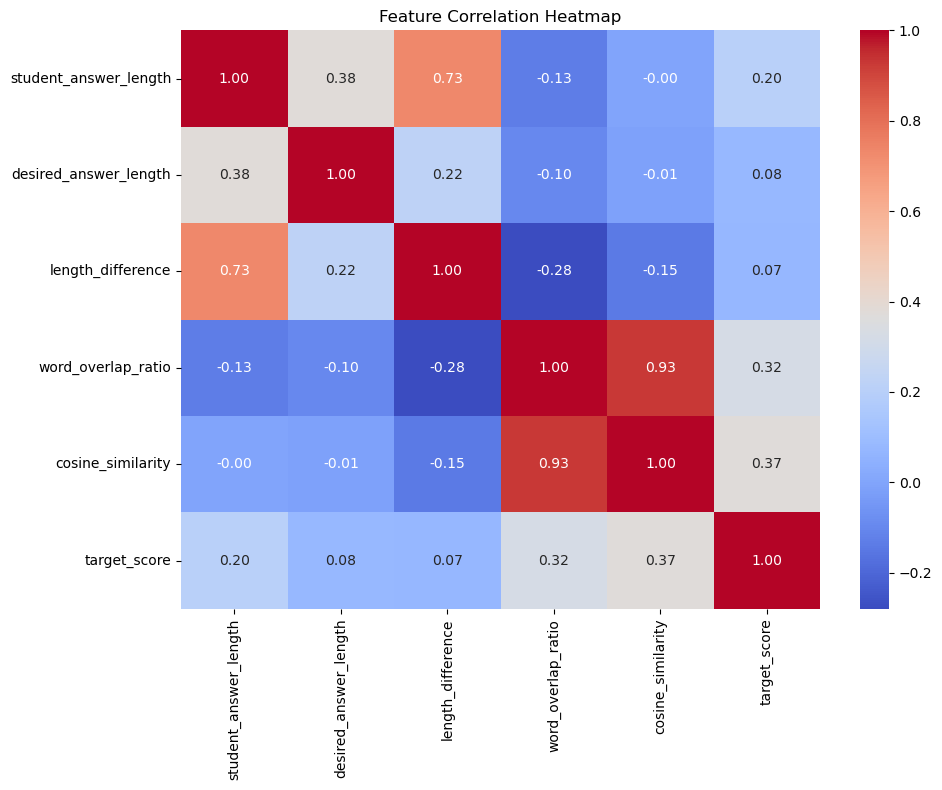

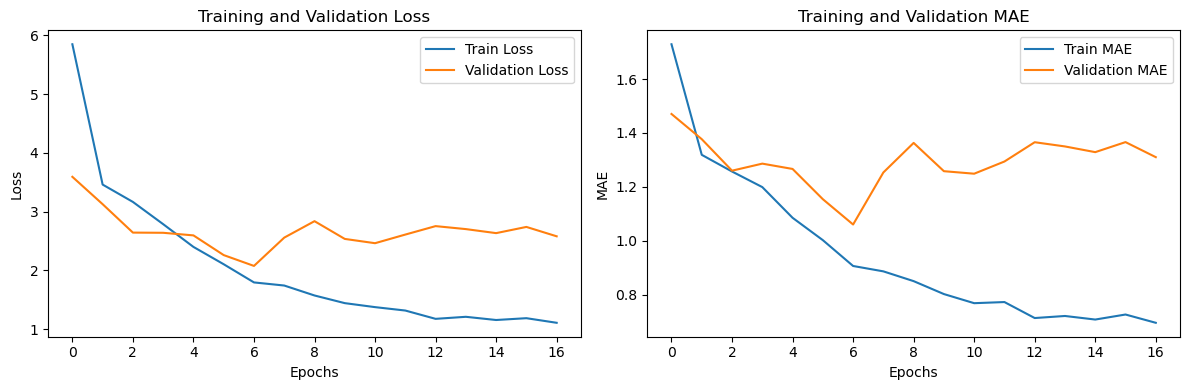

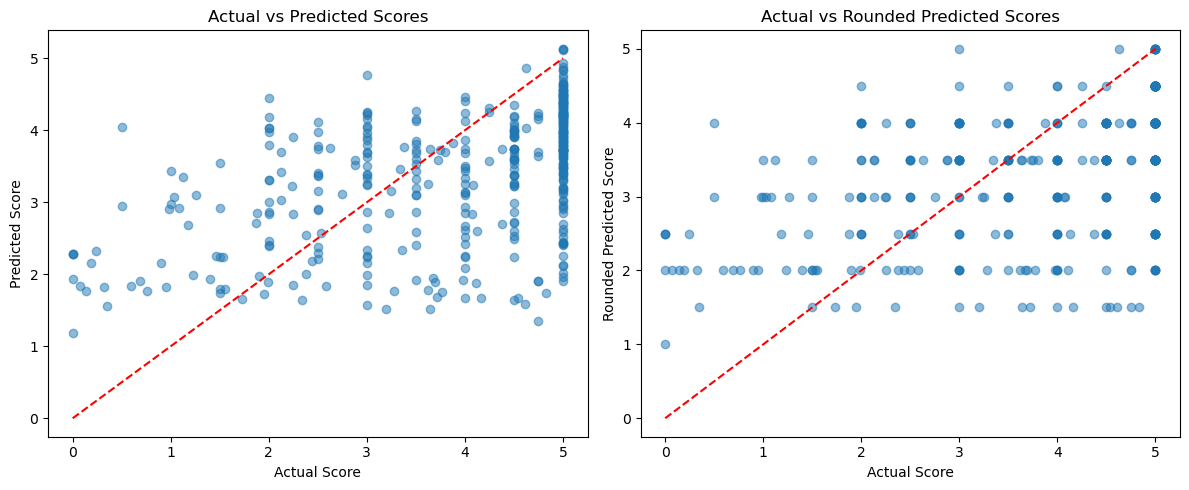

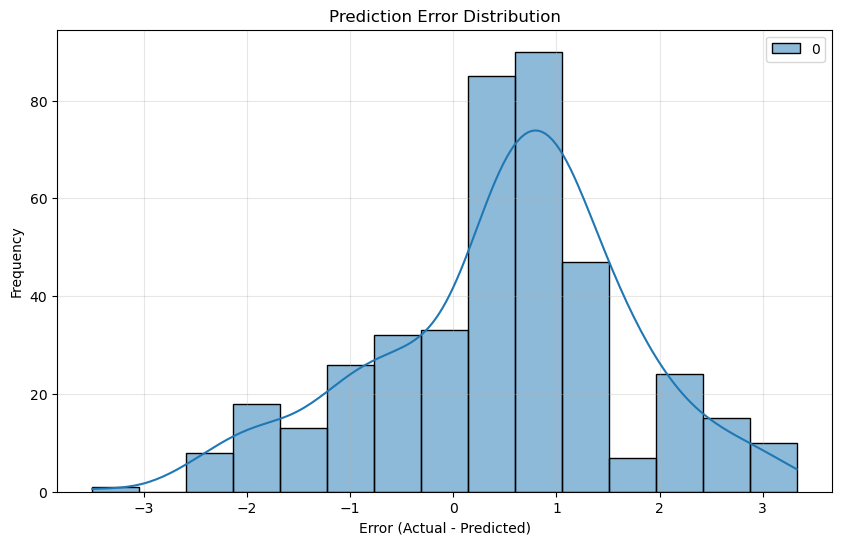

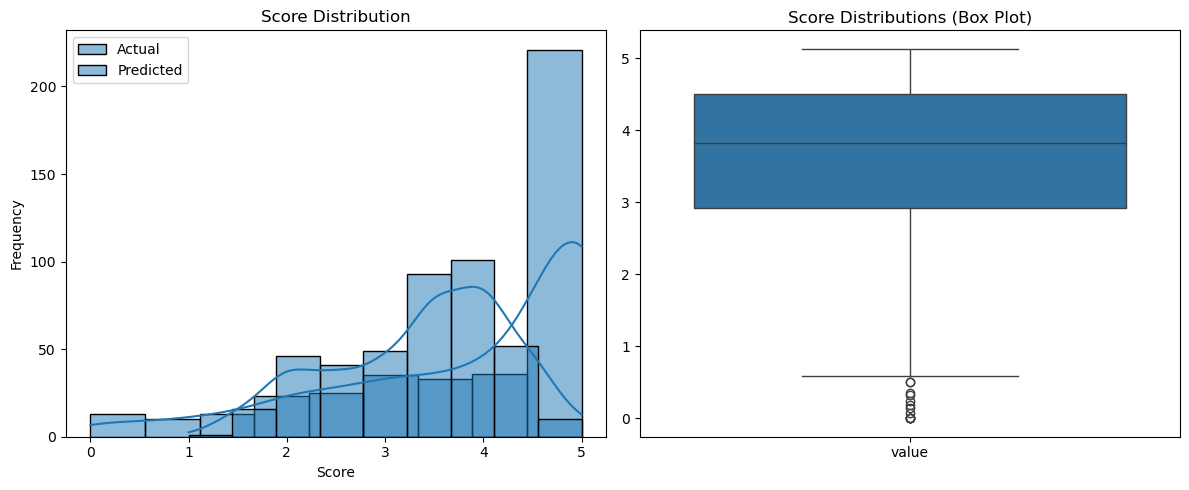

Saving model and results...
Model saved as 'subjective_answer_evaluation.keras'
Tokenizer saved as 'answer_tokenizer.pickle'
Predictions saved as 'prediction_results.csv'
Creating prediction pipeline...


C:\Users\rcoem\anaconda3\Lib\site-packages\keras\src\models\functional.py:225: UserWarning: The structure of `inputs` doesn't match the expected structure: ['student_input', 'additional_features']. Received: the structure of inputs=('*', '*')
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 860ms/step

Example prediction:
Question: What is the role of a prototype?
Desired answer: To simulate the behavior of the actual system.
Student answer: A prototype helps in identifying potential issues in the system design.
Predicted score: 2.5/5
Cosine similarity: 0.1890

Model training and evaluation completed successfully.


In [37]:
# Download required NLTK resources
# !python -m nltk.downloader punkt stopwords wordnet



# Execute main function
if __name__ == "__main__":
    main()